# Predicting future airline revenue from alternative data sources

## Introduction

**Business Context.** You are a research analyst a large investment bank. Your team specializes in analyzing the airline industry and predicting future revenues and costs so that they may recommend investment strategies to their clients. Having just completed data science training, you are eager to apply your newly acquired skills to the problem. Your team already has a lot of data in this domain, but you think that there is additional data than can be used to develop better predictions. Your available data is current up to January 2020 and your goal is to predict the next quarterly earnings coming out in February 2020.

**Business Problem.** Your task is to **build a model to predict the future revenues of United Airlines**

**Analytical Context.** As part of a large financial services company, the following data has already been collected and is in use for your team:

1. The file **"airline_revenues.csv"** contains the quarterly revenue history for every major US airline
2. The file **"airline_fuel_cost.csv"** contains the fuel cost history for every major US airline
3. The file **"oil.csv"** contains the price history of different oil products

You have also been looking for additional data to enhance your model. After considering many different sources, you are primarily interested in:

1. Bureau of Transportation Statistics (**BTS**), which contains seemingly pertinent information for the problem
2. Twitter, which has measures of tweet density as some type of proxy for number of passengers

The case will proceed as follows: you will (1) Look at your team's current data and assess its deficiencies; (2) investigate alternative data sources; (3) scrape the data from these sources and perform data cleaning, EDA, and feature engineering; and finally (4) create a predictive model.

In [1]:
## Load relevant packages

import time

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns


from datetime import datetime
from geopy.geocoders import Nominatim
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Assessing the existing data

Before diving into any data science project, ourr first step should always be to assess the current data to understand which pieces of information we could be missing. In some cases, you will have no data and will have to start from scratch. Here, we already have 3 different data sources and so we should look at each one individually and all of them as a whole to figure out how exactly we should supplement them. At every stage, we should keep in mind our objective: **predicting future revenues**. That means we should be thinking about the following question: **"What pieces of information would be useful for predicting airline revenue?"**.

Let's first look at the airline revenue data. We'll import the file and visualize the data:

In [2]:
airline_revenues = pd.read_csv('./airline_revenues.csv')
airline_revenues

UNIQUE_CARRIER  YEAR  MONTH  DAY  REVENUE  PROFIT  NET_EARNINGS  \
0               AS  2006      3   31    735.4  -125.2         -79.1   
1               AS  2006      6   30    873.0    80.1          55.5   
2               AS  2006      9   30    935.7   -24.0         -17.4   
3               AS  2006     12   31    790.3   -18.2         -11.6   
4               AS  2007      3   31    759.4   -18.1         -10.3   
..             ...   ...    ...  ...      ...     ...           ...   
478             UA  2018      9   30  11003.0  1203.0         836.0   
479             UA  2018     12   31  10491.0   652.0         462.0   
480             UA  2019      3   31   9589.0   495.0         292.0   
481             UA  2019      6   30  11402.0  1472.0        1052.0   
482             UA  2019      9   30  11380.0  1473.0        1024.0   

     EPS_BASIC  EPS_DILUTED  
0        -2.36        -2.36  
1         1.46         1.38  
2        -0.44        -0.44  
3        -0.29        -0.29  
4        -0.26        -0.26  
..         ...          ...  
478       3.07         3.06  
479       1.71         1.70  
480       1.09         1.09  
481       4.03         4.02  
482       4.01         3.99  

[483 rows x 9 columns]

Here are the features of this data:

- **UNIQUE_CARRIER**: The airline that filed the quarterly revenue
- **YEAR**: Year of filing
- **MONTH**: Month of filing
- **DAY**: Day of filing
- **REVENUE**: Revenue reported (in millions)
- **PROFIT**: Profit reported (profit = revenue - costs; in millions)
- **NET_EARNINGS**: Earnings reported (profit minus taxes, interest, and amortization; in millions)
- **EPS_BASIC**: Earnings per share
- **EPS_DILUTED**: Earnings per share after dilution

We are only interested in United because we want to show that this predictive model works for one airline as a proof of concept before building a more general model. As you are new to the team, you are not sure what the code for United is, so you look up the relevant documentation and see that it is **UA**. Since we are only interested in revenues, let's simplify this DataFrame:

In [418]:
# only get United revenues
united_revenues = airline_revenues[airline_revenues['UNIQUE_CARRIER'] == 'UA']

# only keep relevant columns
columns_to_keep = ['YEAR', 'MONTH', 'DAY', 'REVENUE']
united_revenues = united_revenues[columns_to_keep]
united_revenues

YEAR  MONTH  DAY  REVENUE
429  2006      6   30   5113.0
430  2006      9   30   5176.0
431  2006     12   31   4586.0
432  2007      3   31   4373.0
433  2007      6   30   5213.0
434  2007      9   30   5527.0
435  2007     12   31   5030.0
436  2008      3   31   4711.0
437  2008      6   30   5371.0
438  2008      9   30   5565.0
439  2008     12   31   4547.0
440  2009      3   31   3691.0
441  2009      6   30   4018.0
442  2009      9   30   4433.0
443  2009     12   31   4193.0
444  2010      3   31   4260.0
445  2010      6   30   5184.0
446  2010      9   30   5417.0
447  2010     12   31   8464.0
448  2011      3   31   8202.0
449  2011      6   30   9809.0
450  2011      9   30  10171.0
451  2011     12   31   8928.0
452  2012      3   31   8602.0
453  2012      6   30   9939.0
454  2012      9   30   9909.0
455  2012     12   31   8702.0
456  2013      3   31   8721.0
457  2013      6   30  10001.0
458  2013      9   30  10228.0
459  2013     12   31   9329.0
460  2014      3   31   8696.0
461  2014      6   30  10329.0
462  2014      9   30  10563.0
463  2014     12   31   9313.0
464  2015      3   31   8608.0
465  2015      6   30   9914.0
466  2015      9   30  10306.0
467  2015     12   31   9036.0
468  2016      3   31   8195.0
469  2016      6   30   9396.0
470  2016      9   30   9913.0
471  2016     12   31   9052.0
472  2017      3   31   8420.0
473  2017      6   30  10000.0
474  2017      9   30   9878.0
475  2017     12   31   9438.0
476  2018      3   31   9032.0
477  2018      6   30  10777.0
478  2018      9   30  11003.0
479  2018     12   31  10491.0
480  2019      3   31   9589.0
481  2019      6   30  11402.0
482  2019      9   30  11380.0

Now that we have the relevant information, let's plot the data to see what it looks like. Your team uses the following nifty function to plot time series data:

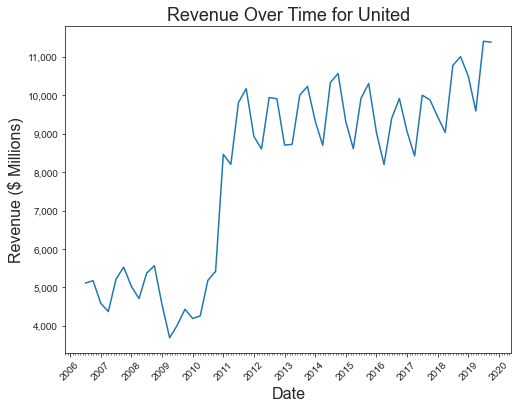

In [420]:
def plot_time_series(dates, values, title, x_label, y_label):
    """
    dates: must be a datetime series for the x axis
    values: the y axis values to plot
    title: string that goes above the plot
    x_label: string that goes on the x-axis
    y_label: string that goes on the y-axis
    """

    years_locator = mdates.YearLocator()
    months_locator = mdates.MonthLocator()
    years_format = mdates.DateFormatter('%Y')

    sns.set_style('ticks')
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6)

    ax.ticklabel_format(axis='y', style='plain')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.xaxis.set_major_locator(years_locator)
    ax.xaxis.set_major_formatter(years_format)
    ax.xaxis.set_minor_locator(months_locator)

    sns.lineplot(x=dates, y=values, ci=None)

    rotation = 45
    plt.setp(ax.get_xticklabels(), rotation=rotation)
    plt.xlabel(x_label, fontsize='16')
    plt.ylabel(y_label, fontsize='16')
    plt.title(title, fontsize='18')

    plt.show()
    
united_revenues['DATE'] = united_revenues.apply(lambda r: datetime(int(r['YEAR']), int(r['MONTH']), int(r['DAY'])), axis=1)
plot_time_series(united_revenues['DATE'], united_revenues['REVENUE'], 'Revenue Over Time for United', 'Date', 'Revenue ($ Millions)')

### Question:

Are there any interesting patterns you notice in this data?

**Answer.** Some thing we notice are seasonal cyclical behaviour, diminished demand in January, and a spike in 2011 caused by the merger of two airlines.

### Exercise 1:

Repeat the above analysis for ```airline_fuel_cost.csv```. You will see many variables; for the sake of the exercise, we are only interested in **QUARTER** and **TOTAL_COST**.

**Answer.**

---------

To complete the analysis, we will now look at the price of oil products via the ```oil.csv``` file:

In [8]:
oil_prices = pd.read_csv('./oil.csv')
oil_prices['DATE'] = pd.to_datetime(oil_prices['DATE'])
oil_prices

DATE  NY_GASOLINE_PRICE  US_GASOLINE_PRICE  YEAR  MONTH  \
0   1990-04-01              0.600              0.617  1990      4   
1   1990-05-01              0.643              0.667  1990      5   
2   1990-06-01              0.646              0.613  1990      6   
3   1990-07-01              0.653              0.602  1990      7   
4   1990-08-01              0.897              0.866  1990      8   
..         ...                ...                ...   ...    ...   
353 2019-09-01              1.726              1.681  2019      9   
354 2019-10-01              1.728              1.646  2019     10   
355 2019-11-01              1.724              1.636  2019     11   
356 2019-12-01              1.713              1.630  2019     12   
357 2020-01-01              1.663              1.592  2020      1   

     KEROSENE_PRICE  
0             0.540  
1             0.515  
2             0.494  
3             0.535  
4             0.791  
..              ...  
353           1.874  
354           1.861  
355           1.824  
356           1.893  
357           1.777  

[358 rows x 6 columns]

From this, we can see that we have the prices for 3 different oil products at the beginning of every month. Let's plot them to see the difference.

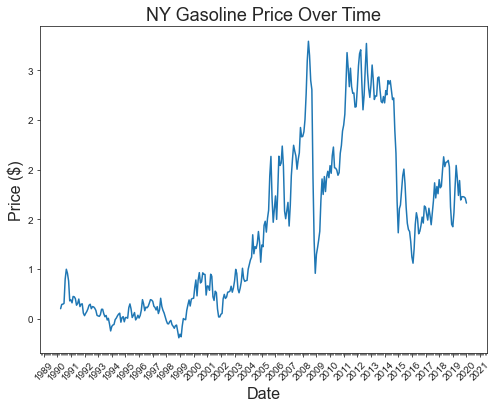

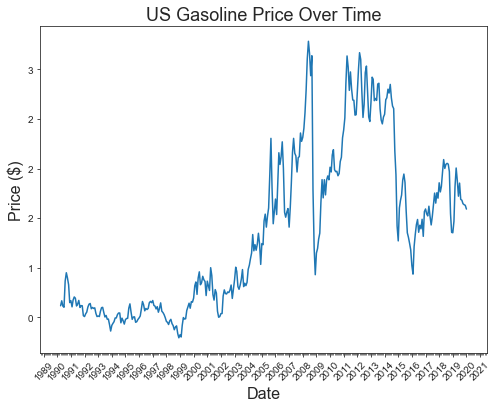

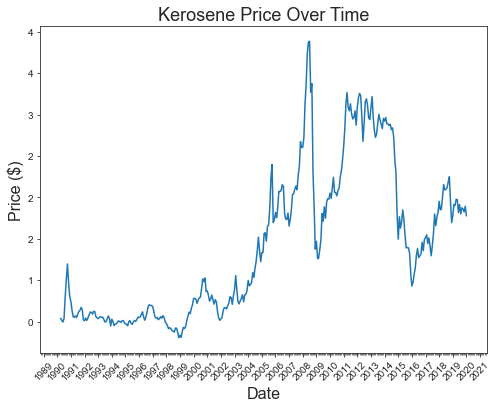

In [9]:
plot_time_series(oil_prices['DATE'], oil_prices['NY_GASOLINE_PRICE'], 'NY Gasoline Price Over Time', 'Date', 'Price ($)')
plot_time_series(oil_prices['DATE'], oil_prices['US_GASOLINE_PRICE'], 'US Gasoline Price Over Time', 'Date', 'Price ($)')
plot_time_series(oil_prices['DATE'], oil_prices['KEROSENE_PRICE'], 'Kerosene Price Over Time', 'Date', 'Price ($)')

From this, we can see that all of them are very highly correlated with minor variations. To our delight, it is also very highly correlated with the airline costs generated earlier. For the purposes of this study, it should be sufficient to choose one of them.

### Question:

Which one should you pick?

**Answer.** Kerosene is what airplanes use to fly and so should be the focus. It is always important to choose variables that have as clear causal relations to what we are predicting as possible. This sort of usage of domain knowledge is crucial to avoid data mining for correlations rather than causations.

In [10]:
columns_to_keep = ['YEAR', 'MONTH', 'DATE', 'KEROSENE_PRICE']
oil_prices = oil_prices[columns_to_keep]
oil_prices

YEAR  MONTH       DATE  KEROSENE_PRICE
0    1990      4 1990-04-01           0.540
1    1990      5 1990-05-01           0.515
2    1990      6 1990-06-01           0.494
3    1990      7 1990-07-01           0.535
4    1990      8 1990-08-01           0.791
..    ...    ...        ...             ...
353  2019      9 2019-09-01           1.874
354  2019     10 2019-10-01           1.861
355  2019     11 2019-11-01           1.824
356  2019     12 2019-12-01           1.893
357  2020      1 2020-01-01           1.777

[358 rows x 4 columns]

In general, but especially in the case of time series, it's important to remember these data collection procedures. In this case, we have 3 time series: revenues, costs, and oil prices. As we know that profit is merely a function of costs, it would be tempting to throw away oil prices. Why do we care about the price of an input into cost when we have the actual cost? The answer lies in the delay between when the data is collected and what is actually happening at any given time. For this case:

1. **Airline Revenue:** The quarterly revenue filed by the airline to the SEC
2. **Airline Costs:** This data takes time to acquire, and your company takes 3 months to compute the costs. Thus, if we are in December, you have all the costs up to September of that year
3. **Oil Prices:** This is a live price that trades publicly. At any given moment in time, we know the price of kerosene exactly

### Exercise 2:

How do these pieces fit together with respect to our goal, and what information are we missing?

**Answer.**

---------

## Supplementing with the BTS data

Now that we know we want to get a prediction of the likely number of passengers on an airline, it would be good to find a dataset of the historical ridership of the airlines. After scouring the Internet, we find the perfect data source from the [Bureau of Transportation Statistics](https://www.transtats.bts.gov/Tables.asp?DB_ID=111&DB_Name=Air%20Carrier%20Statistics%20%28Form%2041%20Traffic%29-%20All%20Carriers&DB_Short_Name=Air%20Carriers). Namely, the T-100 Domestic Market (U.S. Carriers) dataset contains the following attributes:

1. **PASSENGERS:** The number of passengers on the flight segment
2. **UNIQUE_CARRIER:** The carrier ID code
3. **ORIGIN_AIRPORT_ID:** The origin airport ID
4. **DEST_AIRPORT_ID:** The destination airport ID
5. **YEAR:** The year of the flights
6. **MONTH:** The month of the flights
7. **QUARTER:** The quarter of the flights

The way that the data is organized is that it aggregates monthly ridership grouped by airline as well as origin and destination airports. That is, every row represents all the passengers that flew between two cities for a given month and airline. Looking at the data you already have, you decide that you will only use the information since 2012 as this is the first year of operation that United did in the form that we know today. The raw data is available in ```airline_passengers.csv```. Let's investigate what this dataset looks like:

In [11]:
airline_passengers = pd.read_csv('./airline_passengers.csv')
airline_passengers

PASSENGERS UNIQUE_CARRIER     UNIQUE_CARRIER_NAME  ORIGIN_AIRPORT_ID  \
0               0.0             GV          Grant Aviation              15774   
1               0.0             KO  Alaska Central Express              10170   
2               0.0             KO  Alaska Central Express              10245   
3               0.0             KO  Alaska Central Express              10245   
4               0.0             KO  Alaska Central Express              10299   
...             ...            ...                     ...                ...   
2022105     96984.0             AS    Alaska Airlines Inc.              10299   
2022106     97011.0             AS    Alaska Airlines Inc.              14747   
2022107     97098.0             AS    Alaska Airlines Inc.              10299   
2022108     97329.0             DL    Delta Air Lines Inc.              13204   
2022109     97644.0             AS    Alaska Airlines Inc.              14747   

         DEST_AIRPORT_ID  YEAR  QUARTER  MONTH  
0                  11336  2012        1      2  
1                  10299  2012        1      2  
2                  10299  2012        1      2  
3                  10917  2012        1      2  
4                  10170  2012        1      2  
...                  ...   ...      ...    ...  
2022105            14747  2019        3      7  
2022106            10299  2019        2      6  
2022107            14747  2019        3      8  
2022108            10397  2019        1      3  
2022109            10299  2019        3      7  

[2022110 rows x 8 columns]

### Visualizing the data

Let's now visulize this data. It would really be nice to visualize everything on a map to confirm that the data is accurate. The DataFrame shown above would be a nightmare to try and analyze without further transformation.

The first thing we notice is that there is a lot of data here and it would be nice to know which airports those IDs correspond to. As we are only interested in United, that should handle many of the rows. For the airports, you also found [this](https://www.transtats.bts.gov/FieldInfo.asp?Field_Desc=An%20identification%20number%20assigned%20by%20US%20DOT%20to%20identify%20a%20unique%20airline%20%28carrier%29.%20A%20unique%20airline%20%28carrier%29%20is%20defined%20as%20one%20holding%20and%20reporting%20under%20the%20same%20DOT%20certificate%20regardless%20of%20its%20Code%2C%20Name%2C%20or%20holding%20company/corporation.&Field_Type=Num&Lookup_Table=L_AIRLINE_ID&Table_ID=292&SYS_Table_Name=T_T100_MARKET_ALL_CARRIER&Sys_Field_Name=AIRLINE_ID) on the BTS website documentation, which will help us figure out which airports are which. In addition, it also gives the ```LAT``` and ```LON``` (latitude and longitude) for each airport which will help us with map visualizations:

In [12]:
united_passengers = airline_passengers[airline_passengers['UNIQUE_CARRIER'] == 'UA']
united_passengers

PASSENGERS UNIQUE_CARRIER    UNIQUE_CARRIER_NAME  ORIGIN_AIRPORT_ID  \
10070           0.0             UA  United Air Lines Inc.              10140   
10071           0.0             UA  United Air Lines Inc.              10257   
10072           0.0             UA  United Air Lines Inc.              10423   
10073           0.0             UA  United Air Lines Inc.              10423   
10074           0.0             UA  United Air Lines Inc.              10423   
...             ...            ...                    ...                ...   
2022079     84216.0             UA  United Air Lines Inc.              14771   
2022080     85494.0             UA  United Air Lines Inc.              14771   
2022083     87077.0             UA  United Air Lines Inc.              11618   
2022096     92284.0             UA  United Air Lines Inc.              11618   
2022100     93725.0             UA  United Air Lines Inc.              14771   

         DEST_AIRPORT_ID  YEAR  QUARTER  MONTH  
10070              13930  2012        1      1  
10071              12892  2012        1      1  
10072              12892  2012        1      1  
10073              14747  2012        1      1  
10074              14908  2012        1      1  
...                  ...   ...      ...    ...  
2022079            11618  2019        2      5  
2022080            11618  2019        2      6  
2022083            14771  2019        3      7  
2022096            14771  2019        3      8  
2022100            11618  2019        3      8  

[120387 rows x 8 columns]

In [13]:
airports = pd.read_csv('./airports.csv')
airports

Code                                      Description        LAT  \
0     10001           Afognak Lake, AK: Afognak Lake Airport        NaN   
1     10003    Granite Mountain, AK: Bear Creek Mining Strip        NaN   
2     10004                         Lik, AK: Lik Mining Camp        NaN   
3     10005           Little Squaw, AK: Little Squaw Airport  29.383885   
4     10006                       Kizhuyak, AK: Kizhuyak Bay        NaN   
...     ...                                              ...        ...   
6531  16871                     Chester, CT: Chester Airport  41.383545   
6532  16872  Galliano, LA: South Lafourche Leonard Miller Jr        NaN   
6533  16873     Truth Or Consequences, NM: Spaceport America        NaN   
6534  16874     Beijing, China: Beijing Daxing International  39.497356   
6535  99999                          Unknown Point in Alaska        NaN   

             LON  
0            NaN  
1            NaN  
2            NaN  
3     -98.586185  
4            NaN  
...          ...  
6531  -72.505674  
6532         NaN  
6533         NaN  
6534  116.412341  
6535         NaN  

[6536 rows x 4 columns]

As we can see, there are many different airports and many of them are quite small with unknown locations (e.g. "Unknown Point in Alaska"). We also see that some airports have ```NaN```'s listed for their location. Let's try filtering out the airports that United does not fly to and hope that the remaining rows all have their locations listed. First, we need the unique airports:

In [14]:
unique_airports = set(list(united_passengers['ORIGIN_AIRPORT_ID'].unique()))
unique_airports.update(list(united_passengers['DEST_AIRPORT_ID'].unique()))
len(unique_airports)

243

Now, let's restrict the airports DataFrame to those that United flies to and see if any of them are null:

In [15]:
united_airports = airports[airports['Code'].isin(list(unique_airports))]
united_airports[united_airports['LAT'].isnull()]

Code                                        Description  LAT  LON
531   10558  Scottsbluff, NE: Western Neb. Regional/William...  NaN  NaN
685   10713                      Boise, ID: Boise Air Terminal  NaN  NaN
958   10994       Charleston, SC: Charleston AFB/International  NaN  NaN
1189  11233  Cheyenne, WY: Cheyenne Regional/Jerry Olson Field  NaN  NaN
1375  11433            Detroit, MI: Detroit Metro Wayne County  NaN  NaN
1658  11726                        Topeka, KS: Topeka Regional  NaN  NaN
2130  12217  Huntsville, AL: Huntsville International-Carl ...  NaN  NaN
2136  12223    Ashland, WV: Tri-State/Milton J. Ferguson Field  NaN  NaN
2177  12266  Houston, TX: George Bush Intercontinental/Houston  NaN  NaN
2353  12448  Jackson/Vicksburg, MS: Jackson Medgar Wiley Ev...  NaN  NaN
2639  12758  Kona, HI: Ellison Onizuka Kona International a...  NaN  NaN
2822  12951  Lafayette, LA: Lafayette Regional Paul Fournet...  NaN  NaN
2863  12992  Little Rock, AR: Bill and Hillary Clinton Nat ...  NaN  NaN
3100  13234               Midway Island, TT: Sand Island Field  NaN  NaN
3605  13756                   Port Hueneme, CA: Point Mugu NAS  NaN  NaN
3655  13809    Ocala, FL: Ocala International-Jim Taylor Field  NaN  NaN
3889  14054  Pendleton, OR: Eastern Oregon Regional at Pend...  NaN  NaN
3946  14112  St. Petersburg, FL: St Pete Clearwater Interna...  NaN  NaN
4138  14307       Providence, RI: Theodore Francis Green State  NaN  NaN
4357  14574  Roanoke, VA: Roanoke Blacksburg Regional Woodr...  NaN  NaN
4365  14582  Rota, TT: Benjamin Taisacan Manglona Internati...  NaN  NaN
4509  14730  Louisville, KY: Louisville Muhammad Ali Intern...  NaN  NaN
5150  15389  Twin Falls, ID: Joslin Field - Magic Valley Re...  NaN  NaN
5793  16101   Yakima, WA: Yakima Air Terminal/McAllister Field  NaN  NaN

Unfortunately, many of them are null and some of them are large airports (George Bush Intercontinental in Houston is a big hub). What do we do?

It turns out that we can use the [GeoPy](https://geopy.readthedocs.io/en/stable/) package to grab locations given addresses. (In general, this is a good practice; when you have a problem with your data, be resourceful about going online and searching for something out there that can help solve your problem. Don't reinvent the wheel or conversely assume that there is nothing you can do.)

The bad part is that the addresses in the DataFrame are not really standardized. It would be really nice if we had the international 3-letter IATA code for each airport. Fortunately for us, the BTS provides it [here](https://www.bts.gov/topics/airlines-and-airports/world-airport-codes). Let's turn this HTML table into a `pandas` DataFrame:

In [16]:
airport_codes = pd.read_html('https://www.bts.gov/topics/airlines-and-airports/world-airport-codes')[0]
airport_codes

Code                                  City: Airport
0     01A         Afognak Lake, AK: Afognak Lake Airport
1     03A  Granite Mountain, AK: Bear Creek Mining Strip
2     04A                       Lik, AK: Lik Mining Camp
3     05A         Little Squaw, AK: Little Squaw Airport
4     06A                     Kizhuyak, AK: Kizhuyak Bay
...   ...                                            ...
6505  ZXZ             Waterville, WA: Waterville Airport
6506  ZYL                Sylhet, Bangladesh: Savannakhet
6507  ZZU                   Mzuzu, Malawi: Mzuzu Airport
6508  ZZV           Zanesville, OH: Zanesville Municipal
6509  ZZZ                        Unknown Point in Alaska

[6510 rows x 2 columns]

Now we can easily merge this and find the locations using ```GeoPy``` as follows:

In [17]:
geolocator = Nominatim(user_agent="Airport Lat/Long Finder", timeout=100)
geolocator.geocode('IAH airport TX')

Location(2800, North Terminal Road, Houston, Harris County, Texas, 77066, United States of America, (29.9839236, -95.3322023535375, 0.0))

### Exercise 3:

First, merge the ```united_airports``` DataFrame with the IATA codes DataFrame. Then using ```GeoPy```, write a function to assign the missing latitudes and longitudes of the airports that United flies to.

**Answer.**

In [20]:
for i in lat_lons.index:
    united_airports['LAT'].loc[i] = lat_lons.loc[i][0]
    united_airports['LON'].loc[i] = lat_lons.loc[i][1]

In [21]:
united_airports

Code_BTS                                        Description  \
0       10135  Allentown/Bethlehem/Easton, PA: Lehigh Valley ...   
1       10136                      Abilene, TX: Abilene Regional   
2       10140  Albuquerque, NM: Albuquerque International Sun...   
3       10155                            Waco, TX: Waco Regional   
4       10158     Atlantic City, NJ: Atlantic City International   
..        ...                                                ...   
238     15422                             Guam, TT: Andersen AFB   
239     15919      Fayetteville, AR: Northwest Arkansas Regional   
240     16091                            Detroit, MI: Willow Run   
241     16101   Yakima, WA: Yakima Air Terminal/McAllister Field   
242     16133  Youngstown/Warren, OH: Youngstown-Warren Regional   

                    LAT                  LON Code_IATA  \
0               40.6512             -75.4423       ABE   
1               32.4077             -99.6794       ABI   
2               35.0377             -106.611       ABQ   
3               31.6133             -97.2264       ACT   
4               39.4571             -74.5703       ACY   
..                  ...                  ...       ...   
238             13.5811              144.924       UAM   
239             33.2227             -92.8117       XNA   
240             42.2349             -83.5259       YIP   
241  46.566810149999995  -120.53679819122016       YKM   
242             41.2607              -80.675       YNG   

                                         City: Airport  
0    Allentown/Bethlehem/Easton, PA: Lehigh Valley ...  
1                        Abilene, TX: Abilene Regional  
2    Albuquerque, NM: Albuquerque International Sun...  
3                              Waco, TX: Waco Regional  
4       Atlantic City, NJ: Atlantic City International  
..                                                 ...  
238                             Guam, TT: Andersen AFB  
239      Fayetteville, AR: Northwest Arkansas Regional  
240                            Detroit, MI: Willow Run  
241   Yakima, WA: Yakima Air Terminal/McAllister Field  
242  Youngstown/Warren, OH: Youngstown-Warren Regional  

[243 rows x 6 columns]

---------

### Plotting the flights on a map

Now, using [Plotly](https://plotly.com/) we can visualize the data. First, we need the ```LAT``` and ```LON``` for each ```ORIGIN``` and ```DEST``` airport:

In [22]:
united_paths = united_passengers.groupby(['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'UNIQUE_CARRIER', 'YEAR', 'MONTH'])['PASSENGERS'].sum().reset_index()
united_paths = united_paths.merge(airports, left_on='ORIGIN_AIRPORT_ID', right_on='Code')
united_paths = united_paths.merge(airports, left_on='DEST_AIRPORT_ID', right_on='Code', suffixes=("_ORIGIN", "_DEST"))
united_paths

ORIGIN_AIRPORT_ID  DEST_AIRPORT_ID UNIQUE_CARRIER  YEAR  MONTH  \
0                   10135            10821             UA  2015      3   
1                   10140            10821             UA  2012      4   
2                   10140            10821             UA  2012     11   
3                   10140            10821             UA  2015      5   
4                   10257            10821             UA  2015      7   
...                   ...              ...            ...   ...    ...   
116382              14771            10728             UA  2013      6   
116383              14771            10728             UA  2014      6   
116384              14771            13203             UA  2015      9   
116385              15074            13184             UA  2015      9   
116386              15304            16133             UA  2019      9   

        PASSENGERS  Code_ORIGIN  \
0              0.0        10135   
1              6.0        10140   
2              0.0        10140   
3              0.0        10140   
4              0.0        10257   
...            ...          ...   
116382         0.0        14771   
116383         0.0        14771   
116384         0.0        14771   
116385       145.0        15074   
116386       158.0        15304   

                                       Description_ORIGIN  LAT_ORIGIN  \
0       Allentown/Bethlehem/Easton, PA: Lehigh Valley ...   40.651163   
1       Albuquerque, NM: Albuquerque International Sun...   35.037669   
2       Albuquerque, NM: Albuquerque International Sun...   35.037669   
3       Albuquerque, NM: Albuquerque International Sun...   35.037669   
4                        Albany, NY: Albany International   42.748016   
...                                                   ...         ...   
116382     San Francisco, CA: San Francisco International   37.622452   
116383     San Francisco, CA: San Francisco International   37.622452   
116384     San Francisco, CA: San Francisco International   37.622452   
116385                Stillwater, OK: Stillwater Regional   36.161883   
116386                     Tampa, FL: Tampa International   27.979165   

        LON_ORIGIN  Code_DEST  \
0       -75.442254      10821   
1      -106.610968      10821   
2      -106.610968      10821   
3      -106.610968      10821   
4       -73.798556      10821   
...            ...        ...   
116382 -122.384072      10728   
116383 -122.384072      10728   
116384 -122.384072      13203   
116385  -97.087468      13184   
116386  -82.534928      16133   

                                         Description_DEST   LAT_DEST  \
0       Baltimore, MD: Baltimore/Washington Internatio...  39.174526   
1       Baltimore, MD: Baltimore/Washington Internatio...  39.174526   
2       Baltimore, MD: Baltimore/Washington Internatio...  39.174526   
3       Baltimore, MD: Baltimore/Washington Internatio...  39.174526   
4       Baltimore, MD: Baltimore/Washington Internatio...  39.174526   
...                                                   ...        ...   
116382     Beaumont/Port Arthur, TX: Jack Brooks Regional  29.952375   
116383     Beaumont/Port Arthur, TX: Jack Brooks Regional  29.952375   
116384                 Macon, GA: Middle Georgia Regional  32.693840   
116385    Saginaw/Bay City/Midland, MI: MBS International  43.535796   
116386  Youngstown/Warren, OH: Youngstown-Warren Regional  41.260737   

         LON_DEST  
0      -76.671048  
1      -76.671048  
2      -76.671048  
3      -76.671048  
4      -76.671048  
...           ...  
116382 -94.021781  
116383 -94.021781  
116384 -83.648018  
116385 -84.082850  
116386 -80.674979  

[116387 rows x 14 columns]

In [23]:
def plot_flight_paths(paths, airports):
    fig = go.Figure()

    tmp = paths.groupby(['LAT_ORIGIN', 'LON_ORIGIN', 'LAT_DEST', 'LON_DEST']).sum().reset_index()
    max_passengers = float(tmp['PASSENGERS'].max())

    for index, path in tmp.iterrows():
        fig.add_trace(
            go.Scattergeo(
                locationmode = 'USA-states',
                lon = [path['LON_ORIGIN'], path['LON_DEST']],
                lat = [path['LAT_ORIGIN'], path['LAT_DEST']],
                mode = 'lines',
                hoverinfo = "none",
                line = dict(width = 2, color = 'rgb(0, 93, 170)'),
                opacity = path['PASSENGERS'] / max_passengers,
            )
        )

    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = airports['LON'],
        lat = airports['LAT'],
        hoverinfo = 'text',
        text = airports['Description'],
        mode = 'markers',
        marker = dict(
            size = 2,
            color = 'rgb(255, 0, 0)',
            line = dict(
                width = 3,
                color = 'rgba(68, 68, 68, 0)'
            )
        )))

    fig.update_layout(
        title_text = 'Flights by United',
        font = {'size':36},
        showlegend = False,
        geo = go.layout.Geo(
            scope = 'north america',
            projection_type = 'kavrayskiy7',
            showland = True,
            showlakes = True,
            showcountries = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
    )
    
    fig.show()
    
plot_flight_paths(united_paths[united_paths['YEAR'] == 2012], united_airports)

What is Hawaii doing in Hong Kong's location? In this case, if you read the documentation on the BTS website, it would reaffirm that it is simply a wrong latitude and longitude. Let's change those for the LIH flights:

In [24]:
def replace_lat_lon(r, lat_or_lon, origin_or_dest):
    """
    lat_or_lon: LAT or LON
    origin_or_dest: ORIGIN or DEST
    """
    
    LIH_code = 12982
    LIH_lat, LIH_lon = 21.976111, -159.338889
    
    copy_column = lat_or_lon + '_'
    copy_column += origin_or_dest
    
    code_column = 'Code_' + origin_or_dest
    
    if r[code_column] == LIH_code:
        return LIH_lat if lat_or_lon == 'LAT' else LIH_lon
    else:
        return r[copy_column]
    

united_paths['LAT_ORIGIN'] = united_paths.apply(lambda r: replace_lat_lon(r, 'LAT', "ORIGIN"), axis=1)
united_paths['LON_ORIGIN'] = united_paths.apply(lambda r: replace_lat_lon(r, 'LON', "ORIGIN"), axis=1)
united_paths['LAT_DEST'] = united_paths.apply(lambda r: replace_lat_lon(r, 'LAT', "DEST"), axis=1)
united_paths['LON_DEST'] = united_paths.apply(lambda r: replace_lat_lon(r, 'LON', "DEST"), axis=1)

### Exercise 4:

Alter the plotting function above to take in the year and compare the United flights from 2012, 2015, and 2019. What are some trends that you notice?

**Answer.**

---------

### Passengers and revenues

This completes our basic EDA on the BTS data. The point that should be emphasized is that this EDA was used solely as a means to validate the data. We are not yet able to extract hypotheses about revenue from passenger data. Recall that we don't have this information until 3 months after the fact. However, if we did, we should make sure that this is useful information to have.

When dealing with time series, it's important to deal with trends. If two series are predominately dominated by a trend, then their individual fluctions are lost and this may lead to a spurious conclusion. Consider the following example of two random lines:

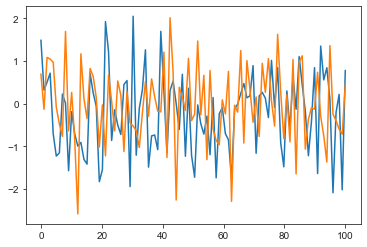

In [29]:
def plot_series_with_slope(m):
    n = 100
    t = np.linspace(0, n, n)

    X_1 = m*t + np.random.normal(size=n)
    X_2 = m*t + np.random.normal(size=n)

    sns.lineplot(t, X_1)
    sns.lineplot(t, X_2)

def get_corr_with_slope(m):
    n = 100
    t = np.linspace(0, 10*n, n)

    X_1 = m*t + np.random.normal(size=n)
    X_2 = m*t + np.random.normal(size=n)
    
    return np.corrcoef(X_1, X_2)

plot_series_with_slope(0)

To the naked eye, these series look incredibly unrelated. Measuring their correlation confirms this:

In [30]:
get_corr_with_slope(0)

array([[ 1.       , -0.0922094],
       [-0.0922094,  1.       ]])

However, what happens if we increase the slope between them?:

array([[1.        , 0.99887768],
       [0.99887768, 1.        ]])

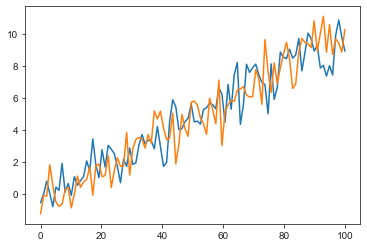

In [31]:
plot_series_with_slope(0.1)
get_corr_with_slope(0.1)

As you can see, the correlation is almost perfect. To give you a sense of how fast the trend can overpower the relationship, here is the correlation as a function of the size of the slope:

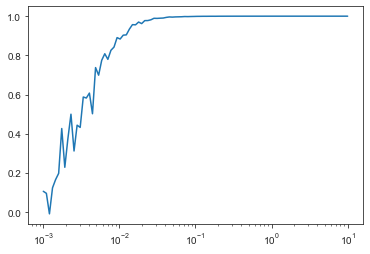

In [32]:
slopes = np.logspace(-3,1,100)
corrs = []

for m in slopes:
    corrs.append(get_corr_with_slope(m)[0,1])
    
f, ax = plt.subplots()
ax.set(xscale='log')
sns.lineplot(x=slopes, y=corrs)

In light of this fact, we need to remove the trend from this line. This is easily done by correlating the difference between points:

In [33]:
m = 1
n = 1000
t = np.linspace(0, 10*n, n)

X_1 = pd.Series(m*t + np.random.normal(size=n))
X_2 = pd.Series(m*t + np.random.normal(size=n))

def time_series_corr(X_1, X_2):
    
    diff_1 = X_1[1:]-X_1.shift()[1:]
    diff_2 = X_2[1:]-X_2.shift()[1:]
    
    return np.corrcoef(diff_1, diff_2)

time_series_corr(X_1, X_2)

array([[1.        , 0.02825692],
       [0.02825692, 1.        ]])

Now that we can correlate two time series, let's check out how passengers and revenues correlate. The first thing we need is to merge the revenues and the passengers DataFrames. As it stands, our passengers DataFrame has a row for each origin and destination airports, for every month. So, we need to aggregate these numbers for every month. However, revenues only come out every quarter, so we will also add the quarter to the passengers DataFrame:

In [34]:
united_passengers_by_month = united_passengers.groupby(['YEAR', 'MONTH']).sum()['PASSENGERS'].reset_index()
united_passengers_by_month['DATE'] = united_passengers_by_month.apply(lambda r: datetime(int(r['YEAR']), int(r['MONTH']), 1), axis=1)
united_passengers_by_month

YEAR  MONTH  PASSENGERS       DATE
0   2012      1   4988564.0 2012-01-01
1   2012      2   4921042.0 2012-02-01
2   2012      3   5952399.0 2012-03-01
3   2012      4   5761602.0 2012-04-01
4   2012      5   5912575.0 2012-05-01
..   ...    ...         ...        ...
91  2019      8   8002440.0 2019-08-01
92  2019      9   6867783.0 2019-09-01
93  2019     10   7562636.0 2019-10-01
94  2019     11   6800650.0 2019-11-01
95  2019     12   7380276.0 2019-12-01

[96 rows x 4 columns]

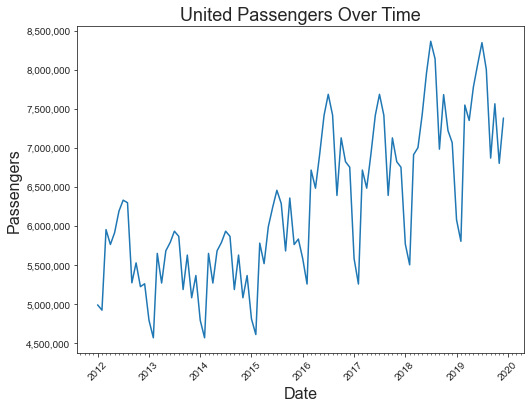

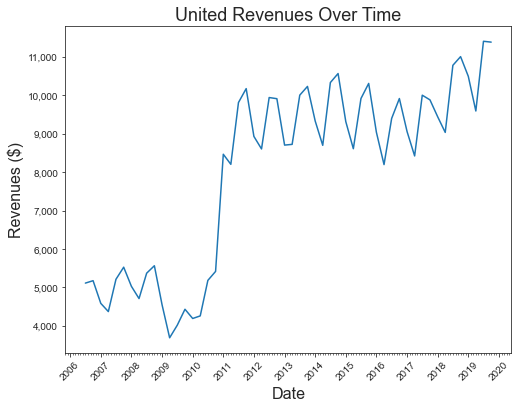

In [35]:
plot_time_series(united_passengers_by_month['DATE'], united_passengers_by_month['PASSENGERS'], 'United Passengers Over Time', 'Date', 'Passengers')
plot_time_series(united_revenues['DATE'], united_revenues['REVENUE'], 'United Revenues Over Time', 'Date', 'Revenues ($)')

Before we can correlate these series, we need to join on the quarter so that the DataFrames match in granularity:

In [36]:
united_passengers_by_quarter = united_passengers.groupby(['YEAR', 'QUARTER']).sum()['PASSENGERS'].reset_index()
united_passengers_by_quarter

YEAR  QUARTER  PASSENGERS
0   2012        1  15862005.0
1   2012        2  17862792.0
2   2012        3  17896866.0
3   2012        4  16007030.0
4   2013        1  15006472.0
5   2013        2  16736598.0
6   2013        3  16982539.0
7   2013        4  16070735.0
8   2014        1  15006472.0
9   2014        2  16736598.0
10  2014        3  16982539.0
11  2014        4  16070735.0
12  2015        1  15197245.0
13  2015        2  17742901.0
14  2015        3  18421501.0
15  2015        4  17948413.0
16  2016        1  17551277.0
17  2016        2  20814077.0
18  2016        3  21490531.0
19  2016        4  20698402.0
20  2017        1  17551277.0
21  2017        2  20814077.0
22  2017        3  21490531.0
23  2017        4  20698402.0
24  2018        1  18179655.0
25  2018        2  22379792.0
26  2018        3  23482892.0
27  2018        4  21964678.0
28  2019        1  19426505.0
29  2019        2  23200245.0
30  2019        3  23215698.0
31  2019        4  21743562.0

In [426]:
united_revenues['QUARTER'] = united_revenues.apply(lambda r: int(r['MONTH']//3), axis=1)
merged_df = pd.merge(united_revenues, united_passengers_by_quarter, on=['YEAR', 'QUARTER'])
time_series_corr(merged_df['REVENUE'], merged_df['PASSENGERS'])

array([[1.        , 0.88444987],
       [0.88444987, 1.        ]])

From this, we can see that passengers are extremely correlated with revenues. Thus, knowing the number of passengers provides a high quality signal to predict revenues. However, we still have the issue of lagged information. Can you think of some data sources that might be able to give us information up to the present?

## Twitter Data

To deal with the lag issue, we will try to predict the current amount of passengers using Twitter. Specifically, we hypothesize that the number of tweets in a given month is correlated with the passengers of that month. United's Twitter can be found in the ```united_tweets.csv``` and has the following simple features:

1. **COUNT:** The number of tweets on Twitter that had United tagged in them
2. **DATE:** The date of the tweets

In [38]:
united_tweets = pd.read_csv('./united_tweets.csv')
united_tweets

COUNT        DATE
0       153  2012-01-01
1       209  2012-01-02
2       223  2012-01-03
3       225  2012-01-04
4       168  2012-01-05
...     ...         ...
2917   1931  2019-12-27
2918   1374  2019-12-28
2919   1441  2019-12-29
2920   1622  2019-12-30
2921   1712  2019-12-31

[2922 rows x 2 columns]

Now we check if these tweets are correlated with passengers by aggregating the tweets by month:

In [39]:
united_tweets['DATE'] = pd.to_datetime(united_tweets['DATE'])
united_tweets['YEAR'] = united_tweets['DATE'].dt.year
united_tweets['MONTH'] = united_tweets['DATE'].dt.month
united_tweets_by_month = united_tweets.groupby(['YEAR', 'MONTH']).sum().reset_index()
united_tweets_by_month

YEAR  MONTH  COUNT
0   2012      1   8371
1   2012      2   6663
2   2012      3  15159
3   2012      4   9774
4   2012      5  35640
..   ...    ...    ...
91  2019      8  52118
92  2019      9  81786
93  2019     10  67936
94  2019     11  43382
95  2019     12  54799

[96 rows x 3 columns]

In [40]:
time_series_corr(united_tweets_by_month['COUNT'], united_passengers_by_month['PASSENGERS'])

array([[ 1.        , -0.04386521],
       [-0.04386521,  1.        ]])

Unfortunately, this is an incredibly disappointing result. Let's see if we can figure out what's going on:

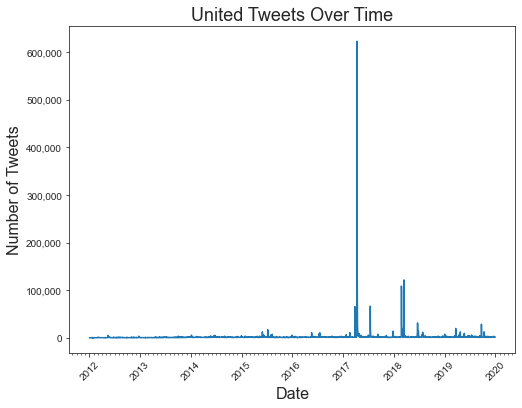

In [41]:
plot_time_series(united_tweets['DATE'], united_tweets['COUNT'], 'United Tweets Over Time', 'Date', 'Number of Tweets')

That is an incredibly large anomaly. Let's check it out.

### Exercise 5:

#### 5.1

Investigate the anomaly. Can you explain what happened?

**Answer.**

---------

#### 5.2

How should we handle the anomaly?

**Answer.**

---------

### Feature engineering our Twitter data

Before we start feature engineering, we need a way to quantify the usefulness of what we are trying to accomplish. In this case, we are looking for a signal that is highly correlated with passenger data of United. Even though our goal is to predict revenues, the big picture idea is to use passenger data to predict revenues and then use Twitter data to predict the most recent passenger data. Thus, we will use our ```time_series_corr()``` function on our engineered feature and the monthly passenger data to quantify it's usefulness.

First, we'll start with a simple moving average for the last thirty days. We will use `pandas` [```rolling()```](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html) function. The ```rolling()``` function is very similar to the ```groupby()``` function. It essentially "groups" the rows in a rolling fashion:

In [43]:
n_days = 30

united_tweets['SMA'] = united_tweets['COUNT'].rolling(n_days).mean()
united_tweets

COUNT       DATE  YEAR  MONTH          SMA
0       153 2012-01-01  2012      1          NaN
1       209 2012-01-02  2012      1          NaN
2       223 2012-01-03  2012      1          NaN
3       225 2012-01-04  2012      1          NaN
4       168 2012-01-05  2012      1          NaN
...     ...        ...   ...    ...          ...
2917   1931 2019-12-27  2019     12  1719.200000
2918   1374 2019-12-28  2019     12  1727.300000
2919   1441 2019-12-29  2019     12  1752.600000
2920   1622 2019-12-30  2019     12  1769.566667
2921   1712 2019-12-31  2019     12  1758.866667

[2922 rows x 5 columns]

Let's plot it and assess it's usefulness:

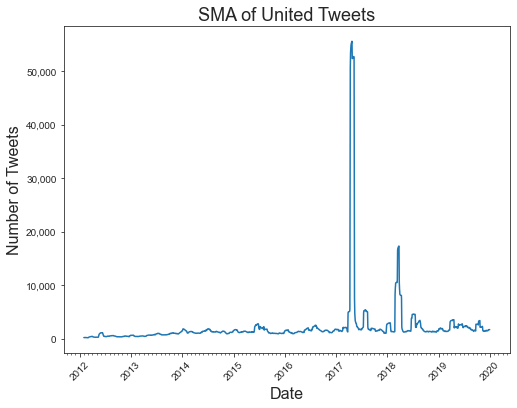

array([[ 1.        , -0.01396179],
       [-0.01396179,  1.        ]])

In [44]:
plot_time_series(united_tweets['DATE'].iloc[n_days:], united_tweets['SMA'].iloc[n_days:], 'SMA of United Tweets', 'Date', 'Number of Tweets')

# need to convert tweets to month
time_series_corr(united_tweets.iloc[n_days:].groupby(['YEAR', 'MONTH']).mean()['SMA'], united_passengers_by_month['PASSENGERS'])

The nice thing about the ```rolling()``` function is that it let's you apply different weights to the rolling window. For example, if you want to favor the most recent data points, all you have to do is supply the ```win_type``` argument. See the documentation link above for all of the different window types. Or, you can use the [```ewm()```](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html) function if you want an exponential moving average:

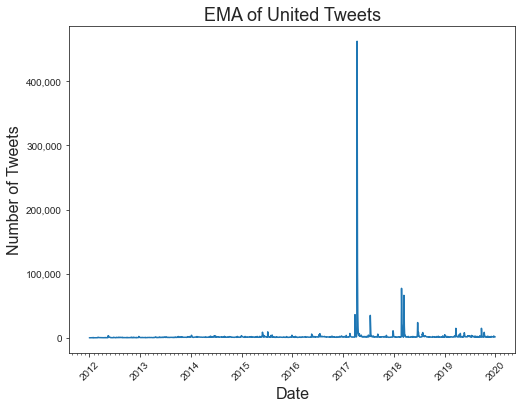

array([[ 1.        , -0.05028845],
       [-0.05028845,  1.        ]])

In [45]:
alpha = 0.5
united_tweets['EMA'] = united_tweets['COUNT'].ewm(alpha=alpha).mean()
plot_time_series(united_tweets['DATE'], united_tweets['EMA'], 'EMA of United Tweets', 'Date', 'Number of Tweets')

# need to convert tweets to month
time_series_corr(united_tweets.groupby(['YEAR', 'MONTH']).mean()['EMA'], united_passengers_by_month['PASSENGERS'])

As you can see, this is still disappointing. The root cause is the harsh spike up in 2017. Is there another aggregation function that is harsher to big spikes? Yes! The median function:

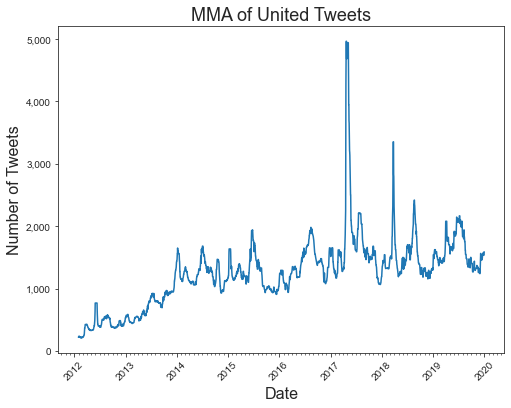

array([[1.        , 0.14861551],
       [0.14861551, 1.        ]])

In [46]:
united_tweets['MMA'] = united_tweets['COUNT'].rolling(n_days).median()
plot_time_series(united_tweets['DATE'].iloc[n_days:], united_tweets['MMA'].iloc[n_days:], 'MMA of United Tweets', 'Date', 'Number of Tweets')

# need to convert tweets to month
time_series_corr(united_tweets.iloc[n_days:].groupby(['YEAR', 'MONTH']).mean()['MMA'], united_passengers_by_month['PASSENGERS'])

Now we are making some progress! But the spikes are still problematic. If we applied the median over a larger range, the spikes disappear:

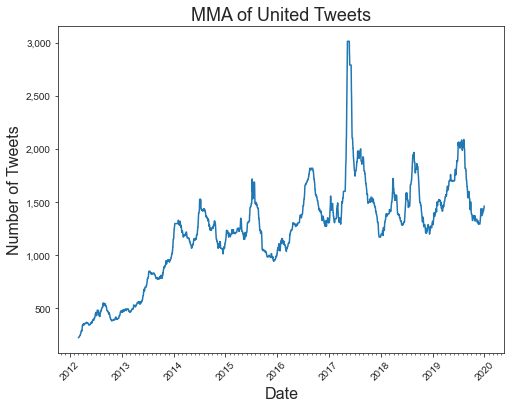

In [47]:
n_days = 60
united_tweets['MMA'] = united_tweets['COUNT'].rolling(n_days).median()

plot_time_series(united_tweets['DATE'].iloc[n_days:], united_tweets['MMA'].iloc[n_days:], 'MMA of United Tweets', 'Date', 'Number of Tweets')

However, the problem is that we are capped by the size of the window because then we start losing information of the seasons. One easy thing we can do is take the median of the rolling median:

In [48]:
n_days = 30
united_tweets['MMA'] = united_tweets['COUNT'].rolling(n_days).median()

# need to convert tweets to month
time_series_corr(united_tweets.iloc[n_days:].groupby(['YEAR', 'MONTH']).median()['MMA'], united_passengers_by_month['PASSENGERS'])

array([[1.        , 0.20493507],
       [0.20493507, 1.        ]])

Again, some progress, but the spikes still need to be dealt with. What if we group by month first instead of doing a rolling window?:

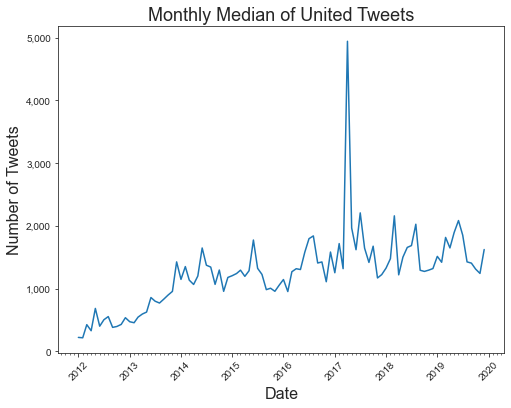

array([[1.       , 0.1120301],
       [0.1120301, 1.       ]])

In [49]:
united_tweets_by_month = united_tweets.groupby(['YEAR', 'MONTH'])['COUNT'].median().reset_index()
plot_time_series(united_passengers_by_month['DATE'], united_tweets_by_month['COUNT'], 'Monthly Median of United Tweets', 'Date', 'Number of Tweets')
time_series_corr(united_tweets_by_month['COUNT'], united_passengers_by_month['PASSENGERS'])

That's a step backwards, but still a valiant effort.

### Exercise 6:

Try to engineer the tweets time series to remove the big spikes and beat the correlation of $0.2$ that the median rolling window yielded.

**Answer.**

---------

## Building the model

Now that we have all of our data, let's summarize what we have:

**Dependent Variables:**

1. Airlines passengers: latest available, 3 months ago - ```united_passengers_by_month```
2. Airlines costs: latest available, 3 months ago - ```united_costs```
3. Oil costs: latest available, present - ```oil_prices```
4. Tweet count: latest available, present - ```united_tweets_by_month```

**Target Variable:**

1. Revenues: Available every quarter

Everything is a time series, so we need to decide how much history we want to feed into the algorithm. Having more history should help with better predictions, but most of the useful information is in the nearby history. We also have to decide which variables to include. Here are two examples:

$Revenue_i = f(Passengers_{i-3}, Costs_{i-2}, Kerosene_i, Tweets_i)$

This represents using only the most latest passengers, costs, and tweets. On the other end of the spectrum we could have something like:

$Revenue_i = f(Passengers_{i-3}, Passengers_{i-4}, Passengers_{i-5}, Passengers_{i-6}, Passengers_{i-7}, Passengers_{i-8}, Passengers_{i-9}, Passengers_{i-10}, Passengers_{i-11}, Passengers_{i-12}, Passengers_{i-13}, Passengers_{i-14}, Costs_{i-2}, Costs_{i-3}, Costs_{i-4}, Costs_{i-5}, Costs_{i-6}, Costs_{i-7}, Costs_{i-8}, Costs_{i-9}, Costs_{i-10}, Costs_{i-11}, Costs_{i-12}, Costs_{i-13}, Costs_{i-14}, Kerosene_{i}, Kerosene_{i-1}, Kerosene_{i-2}, Kerosene_{i-3}, Kerosene_{i-4}, Kerosene_{i-5}, Kerosene_{i-6}, Kerosene_{i-7}, Kerosene_{i-8}, Kerosene_{i-9}, Kerosene_{i-10}, Kerosene_{i-11}, Tweets_{i}, Tweets_{i-1}, Tweets_{i-2}, Tweets_{i-3}, Tweets_{i-4}, Tweets_{i-5}, Tweets_{i-6}, Tweets_{i-7}, Tweets_{i-8}, Tweets_{i-9}, Tweets_{i-10}, Tweets_{i-11})$

which would be including the last 12 months of data for every time series we have. Let's evaluate both of these models. First, we need to introduce **lagged variables** into our data by using the `pandas` ```shift()``` function:

In [64]:
oil_prices[['KEROSENE_PRICE']]

KEROSENE_PRICE
0             0.540
1             0.515
2             0.494
3             0.535
4             0.791
..              ...
353           1.874
354           1.861
355           1.824
356           1.893
357           1.777

[358 rows x 1 columns]

In [65]:
oil_prices[['KEROSENE_PRICE']].shift(1)

KEROSENE_PRICE
0               NaN
1             0.540
2             0.515
3             0.494
4             0.535
..              ...
353           1.800
354           1.874
355           1.861
356           1.824
357           1.893

[358 rows x 1 columns]

Finally, we have to merge these lagged DataFrames with our target variable and make dummy variables for the quarters of the revenue filing. Dummy variables are used here because the quarters aren't an ordinal. That is, if the effect of revenue in the first quarter is $\beta$ then the effect in the fourth quarter will **not** be $4\beta$:

In [491]:
def make_lag_dfs(num_oil_lag, num_passengers_lag, num_costs_lag, num_tweets_lag):
    X = pd.DataFrame()

    start_date = datetime(2012,1,1)
    end_date = datetime(2020,1,1)

    X = oil_prices[(oil_prices['DATE'] >= start_date) & (oil_prices['DATE'] <= end_date)]

    # oil price lag

    for i in range(num_oil_lag):
        name = f"KEROSENE_PRICE_{i}"
        X[name] = X['KEROSENE_PRICE'].shift(i)

    del X['KEROSENE_PRICE']

    # passengers lag
    columns_to_keep = ['YEAR', 'MONTH', 'PASSENGERS']

    X = X.merge(united_passengers_by_month[
        (united_passengers_by_month['DATE'] >= start_date) & (united_passengers_by_month['DATE'] <= end_date)]
                [columns_to_keep], on=['YEAR', 'MONTH'], how='outer')

    for i in range(3, 3+num_passengers_lag):
        name = f"PASSENGERS_{i}"
        X[name] = X['PASSENGERS'].shift(i)

    del X['PASSENGERS']

    # costs lag
    columns_to_keep = ['YEAR', 'MONTH', 'TOTAL_COST']

    X = X.merge(united_costs[(united_costs['DATE'] >= start_date) & (united_costs['DATE'] <= end_date)]
                [columns_to_keep], on=['YEAR', 'MONTH'], how='outer')

    for i in range(3, 3+num_costs_lag):
        name = f"TOTAL_COST_{i}"
        X[name] = X['TOTAL_COST'].shift(i)

    del X['TOTAL_COST']

    # tweets lag
    columns_to_keep = ['YEAR', 'MONTH', 'SMOOTH_SMA']

    X = X.merge(united_tweets_by_month[columns_to_keep], on=['YEAR', 'MONTH'], how='outer')

    for i in range(num_tweets_lag):
        name = f"TWEETS_{i}"
        X[name] = X['SMOOTH_SMA'].shift(i)

    del X['SMOOTH_SMA']
    
    columns_to_keep = ['YEAR', 'MONTH', 'REVENUE']
    X = pd.merge(X, united_revenues[columns_to_keep], on=['YEAR', 'MONTH'])
    
    X = X.dropna()
    
    dates = X.apply(lambda r: datetime(r['YEAR'], r['MONTH'], 30) , axis=1)
    del X['DATE']
    del X['YEAR']
    
    X = pd.get_dummies(X, columns=['MONTH'])

    y = X['REVENUE']
    del X['REVENUE']

    return X, y, dates

X_minimal, y_minimal, dates_minimal = make_lag_dfs(1, 1, 1, 1)
X_maximal, y_maximal, dates_maximal = make_lag_dfs(12, 12, 12, 12)

In [492]:
X_minimal.head()

KEROSENE_PRICE_0  PASSENGERS_3  TOTAL_COST_3    TWEETS_0  MONTH_3  MONTH_6  \
1             2.678     5952399.0   933220245.0  597.237122        0        1   
2             3.191     6188615.0   855369144.0  492.057778        0        0   
3             2.940     5271258.0   868453153.0  506.336762        0        0   
4             2.969     5258843.0   791441194.0  555.035484        1        0   
5             2.769     5647678.0   854589487.0  798.059176        0        1   

   MONTH_9  MONTH_12  
1        0         0  
2        1         0  
3        0         1  
4        0         0  
5        0         0

In [493]:
X_maximal.head()

KEROSENE_PRICE_0  KEROSENE_PRICE_1  KEROSENE_PRICE_2  KEROSENE_PRICE_3  \
4             2.969             3.218             3.091             2.940   
5             2.769             2.725             2.808             2.969   
6             2.934             3.003             2.894             2.769   
7             2.955             2.830             2.885             2.934   
8             2.890             2.965             2.921             2.955   

   KEROSENE_PRICE_4  KEROSENE_PRICE_5  KEROSENE_PRICE_6  KEROSENE_PRICE_7  \
4             2.960             3.111             3.191             3.156   
5             3.218             3.091             2.940             2.960   
6             2.725             2.808             2.969             3.218   
7             3.003             2.894             2.769             2.725   
8             2.830             2.885             2.934             3.003   

   KEROSENE_PRICE_8  KEROSENE_PRICE_9  ...    TWEETS_6    TWEETS_7  \
4             2.892             2.678  ...  492.057778  608.364516   
5             3.111             3.191  ...  506.336762  517.800000   
6             3.091             2.940  ...  555.035484  479.415476   
7             2.808             2.969  ...  798.059176  689.302008   
8             2.894             2.769  ...  825.781111  788.433409   

     TWEETS_8    TWEETS_9   TWEETS_10   TWEETS_11  MONTH_3  MONTH_6  MONTH_9  \
4  502.340860  597.237122  438.279210  360.668139        1        0        0   
5  418.697849  492.057778  608.364516  502.340860        0        1        0   
6  579.333740  506.336762  517.800000  418.697849        0        0        1   
7  558.810386  555.035484  479.415476  579.333740        0        0        0   
8  967.932636  798.059176  689.302008  558.810386        1        0        0   

   MONTH_12  
4         0  
5         0  
6         0  
7         1  
8         0  

[5 rows x 52 columns]

As we can see, the price you pay for 12 months of historical data is 3 data points which is pretty significant for 30 overall data points. To assess the performance, we will train on 2012 to 2018 and predict the last 3 data points in 2019. The model we will begin with is a simple linear model. Let's also turn the month variable into a dummy variable as we know that it should not be treated as an ordinal:

In [494]:
dates_train = dates_minimal[:-3]
dates_test = dates_maximal[-3:]

X_train, y_train = X_minimal[:-3], y_minimal[:-3]
X_test, y_test = X_minimal[-3:], y_minimal[-3:]

clf = linear_model.LinearRegression()

clf.fit(X_train, y_train)

pred = clf.predict(X_train)
mean_error = (abs(pred-y_train)/y_train).mean()
standard_deviation = (abs(pred-y_train)/y_train).std()

print('Training Error:')

print(f'Mean Error: {mean_error}')
print(f'Standard Deviation of Error: {standard_deviation}')

print('Test Error:')

pred = clf.predict(X_test)
mean_error = (abs(pred-y_test)/y_test).mean()
standard_deviation = (abs(pred-y_test)/y_test).std()

print(f'Mean Error: {mean_error}')
print(f'Standard Deviation of Error: {standard_deviation}')

Training Error:
Mean Error: 0.023000193289723508
Standard Deviation of Error: 0.016760950133615043
Test Error:
Mean Error: 0.04553267140017184
Standard Deviation of Error: 0.0010661994746177037


While the numbers don't lie, we can clearly see that the maximal model is overfitting:

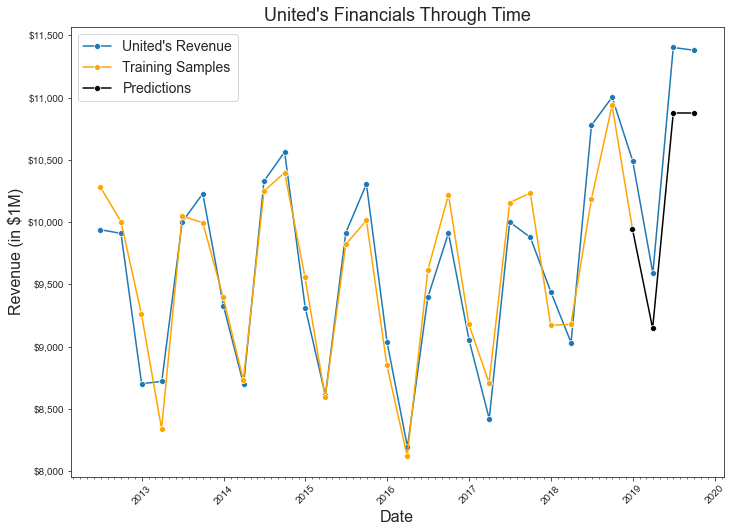

In [495]:
def plot_prediction_time_series(dates_train, train, dates_test, pred, dates_truth, truth, title, x_label, y_label):
   
    years_locator = mdates.YearLocator()
    months_locator = mdates.MonthLocator()
    years_format = mdates.DateFormatter('%Y')
    
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)

    ax.ticklabel_format(axis='y', style='plain')

    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))

    ax.xaxis.set_major_locator(years_locator)
    ax.xaxis.set_major_formatter(years_format)
    ax.xaxis.set_minor_locator(months_locator)

    sns.lineplot(x=dates_truth, y=truth, marker='o')
    sns.lineplot(x=dates_train, y=train, color='orange', marker='o')

    dates_pred = list(dates_train[-1:]) + list(dates_test)
    plot_pred = list(train[-1:]) + list(pred)

    sns.lineplot(x=dates_pred, y=plot_pred, color='black', marker='o')

    plt.legend(labels=['United\'s Revenue', 'Training Samples', 'Predictions'], fontsize='14')

    rotation = 45
    plt.setp(ax.get_xticklabels(), rotation=rotation)
    plt.title('United\'s Financials Through Time', fontsize='18')
    plt.xlabel('Date', fontsize='16')
    plt.ylabel('Revenue (in $1M)', fontsize='16')

    plt.show()
    
plot_prediction_time_series(dates_train, clf.predict(X_train), dates_test, pred, united_revenues[-30:]['DATE'], united_revenues[-30:]['REVENUE'], 'Predicted United Revenues', 'Date', 'Revenue ($ Million)')


In [496]:
dates_train = dates_maximal[:-3]
dates_test = dates_maximal[-3:]

X_train, y_train = X_maximal[:-3], y_maximal[:-3]
X_test, y_test = X_maximal[-3:], y_maximal[-3:]

clf = linear_model.LinearRegression()
clf.fit(X_train, y_train)

pred = clf.predict(X_train)
mean_error = (abs(pred-y_train)/y_train).mean()
standard_deviation = (abs(pred-y_train)/y_train).std()

print('Training Error:')

print(f'Mean Error: {mean_error}')
print(f'Standard Deviation of Error: {standard_deviation}')

print('Test Error:')

pred = clf.predict(X_test)
mean_error = (abs(pred-y_test)/y_test).mean()
standard_deviation = (abs(pred-y_test)/y_test).std()

print(f'Mean Error: {mean_error}')
print(f'Standard Deviation of Error: {standard_deviation}')

Training Error:
Mean Error: 9.948011236735745e-16
Standard Deviation of Error: 4.524078871232714e-16
Test Error:
Mean Error: 0.03308719224824339
Standard Deviation of Error: 0.01671403512223153


24
24


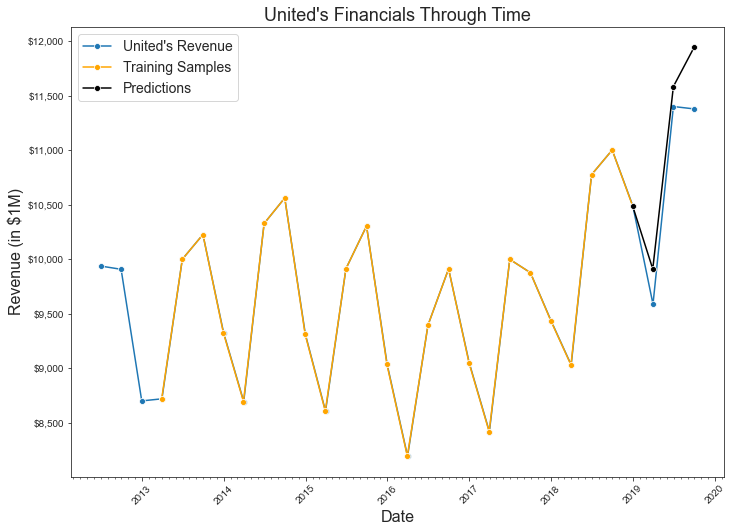

In [497]:
plot_prediction_time_series(dates_train, clf.predict(X_train), dates_test, pred, united_revenues[-30:]['DATE'], united_revenues[-30:]['REVENUE'], 'Predicted United Revenues', 'Date', 'Revenue ($ Million)')


As you can see, throwing all the variables at the problem actually makes the model overfit by perfectly tracking the training date. Now, we can see that our lower bound for model performance is something like 3% on the test date. There is still much work that could be done here, such as considering interaction terms and other models.

### Exercise 7:

Come up with your best model for predicting future revenues. Don't forget you can use the ```make_lag_dfs()``` function to give you the proper DataFrame with the lagged variables and dummy variables of the quarter.

**Answer.**

---------

Finally, this case study wouldn't be complete without validating the actual revenue for Q4 of 2019, which was $10.888 billion:

In [552]:
new_row = pd.DataFrame([[2019, 12, 31, 10888, datetime(2019,12,31), 4]], columns=united_revenues.columns)
tmp = united_revenues.copy()
united_revenues = united_revenues.append(new_row)

X, y, dates = make_lag_dfs(0,12,12,12)
united_revenues = tmp.copy()

print(f"Final prediction for Q4 2019 is: {clf.predict(X.iloc[-1:])[0]} vs. an expected 10888")

Final prediction for Q4 2019 is: 9949.131430098587 vs. an expected 10888


That represents a roughly 2.2% error; not bad for a model with only 30 training examples!

## Conclusion

In this case, we did a data science project end-to-end, from collecting data and cleaning it, visualizing the data to validate it, designing some new features from the data, and finally building a model to complete the task of predict airline revenue. We saw common problems at each step:

1. Cleaning: error in the data collected
2. Visualizing: how to visualize complicated data
3. Feature engineering: our raw data needed to be carefully transformed to yield a signal
4. Predicting: overfitting

At each stage, we overcame the issue by not losing sight of the goal and keeping in mind the big picture. By understanding our problem and its real-world influences, we were able to achieve a better result in the end.

## Takeaways

Data science is much more than knowing the latest methods and the tools of the trade. If you ask what makes a good carpenter, you would not answer with "someone that knows how to use a hammer". These should be the points you should focus on from this case:

1. Understand your problem first. If you don't have a clear objective, you'll be left wandering. Assess your data according to your goal.

3. Real data science requires trial and error. Even the best data sources make mistakes. You should constantly validate input and output.

4. Visualizing data is key to understanding. Imagine removing all the graphs from this case and working solely with metrics. While useful, metrics will never be as insightful as plots for understanding failure mechanisms.

5. Finally, the modeling step is arguably the easiest and least important step for project success. By sticking to simple linear models, we were able to achieve very good results. However, leaving out the Twitter data entirely could have severely compromised our outcomes.